# Create a Microcircuit using Snudda

This examples shows how to setup a custom network from scratch. There are helper methods specifically designed for the Striatum, but Snudda can also be used for other brain structures. Here we instead use the base functionality to show how to build your own custom network using Snudda.

In [1]:
import os

network_path = os.path.join("networks", "example_microcircuit")

### Create the Structure Mesh

The neurons for your microcircuit can be placed within one or more meshes. For this example we create a simple cube mesh centred around origo.

In [2]:
from snudda.place import create_cube_mesh
mesh_file = os.path.join(network_path, "mesh", "cube-mesh.obj")
create_cube_mesh(file_name=mesh_file, centre_point=(0,0,0), side_len=170e-6, description="EBRAINS example mesh")

## Create the Network Config File

The network is defined using the ```network-config.json```, you can either write it manually, or use python to help create it for you. We use ```snudda_data``` to specify the folder that contains morphologies, experimental parameters etc. The folder ```snudda_data``` structure contains a ```neurons``` folder with morpologies and neuron parameters, and a ```mechanisms``` subfolder with the NEURON mechanisms. There is a ```synapses``` folder with synaptic parameters, and a ```mesh``` folder that can be used.

### Define which neurons should be in the network

First we add the neurons. Striatum has around 80500 neurons per cubic milimeter, so we place 405 neurons in a cube with 0.170 mm side.

We use ```add_neurons``` where we specify the name of the neurons, how many they are (```num_neurons```), what ```volume_id``` they are placed within, and which folder the neurons are located in (```$DATA``` will be replaced with the ```snudda_data``` path).

In [3]:
snudda_data = os.path.join("..", "..", "..", "snudda", "data")

from snudda import SnuddaInit

si = SnuddaInit(network_path=network_path, snudda_data=snudda_data)

si.define_structure(struct_name="EBRAINS example", struct_mesh=mesh_file)
si.add_neurons(name="dSPN", num_neurons=200, volume_id="EBRAINS example",
                neuron_dir=os.path.join("$DATA","neurons","striatum","dspn"))
si.add_neurons(name="iSPN", num_neurons=200, volume_id="EBRAINS example",
                neuron_dir=os.path.join("$DATA","neurons","striatum","ispn"))
si.add_neurons(name="FS", num_neurons=5, volume_id="EBRAINS example",
                neuron_dir=os.path.join("$DATA","neurons","striatum","fs"))

Adding neurons: dSPN from dir /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn
Adding neurons: iSPN from dir /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/ispn
Adding neurons: FS from dir /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/fs


### Define connectivity for FS neurons

We use ```add_neuron_target``` to setup the connectivity of the network. Here ```neuron_name``` is the presynaptic neuron, and ```target_name``` is the post synaptic neuron, ```connection_type``` specifies what connection type it is and ```mod_file``` names the NEURON modfile responsible for modelling the channel. To target proximal or distal parts of dendrites we use ```dist_pruning``` which is a ```numexpr``` expression (here ```d``` is the dendritic distance to the soma). The ```conductance``` of the synapse needs to be set, and we can also specify additional channel parameters either by refering to a ```parameterfile``` or by using the ```channel_param_dictionary```, both lets you set parameters in the NEURON channel mod file. Finally you can choose if you want the pruning of the synapses to try and cluster the synapses together by setting ```cluster_synapses``` (boolean), synapses with many neighbouring synapses are more likely to be kept.

The pruning parameters need an explanation. For details of ```f1```, ```soft_max```, ```mu2``` and ```a3``` please see [Hjorth, Hellgren Kotaleski, Kozlov 2021](https://link.springer.com/article/10.1007/s12021-021-09531-w).



In [4]:
FS_dist_dep_pruning = "exp(-(0.5*d/60e-6)**2)"  # FS form mainly proximal synapses

FS_gGABA = [1.1e-9, 1.5e-9]           # cond (1nS Gittis et al 2010), (cond, std)
FS_to_LTS_gGABA = [1.1e-10, 1.5e-10]  # cond (1nS Gittis et al 2010)
FS_gGapJunction = [0.5e-9, 0.1e-9]    # (gap junctions: 0.5nS, P=0.3 -- Galarreta Hestrin 2002, Koos Tepper 1999)
                                      # total 8.4nS ?? Gittis et al 2010??

# File with synapse parameters
pfFSFS = None  # Gittis 2010?
pfFSdSPN = os.path.join("$SNUDDA_DATA", "synapses", "striatum", "PlanertFitting-FD-tmgaba-fit.json")
pfFSiSPN = os.path.join("$SNUDDA_DATA", "synapses", "striatum", "PlanertFitting-FI-tmgaba-fit.json")

cluster_FS_synapses = False

# Increased from a3=0.1 to a3=0.7 to match FS-FS connectivity from Gittis
si.add_neuron_target(neuron_name="FS",
                     target_name="FS",
                     connection_type="GABA",
                     dist_pruning=None,
                     f1=0.15, soft_max=5, mu2=2, a3=1,
                     conductance=FS_gGABA,
                     cluster_synapses=cluster_FS_synapses,
                     parameter_file=pfFSFS,
                     mod_file="tmGabaA",
                     channel_param_dictionary={"tau1": (1.33e-3, 1e3),
                                                 "tau2": (5.7e-3, 1e3)})
si.add_neuron_target(neuron_name="FS",
                     target_name="dSPN",
                     connection_type="GABA",
                     dist_pruning=FS_dist_dep_pruning,
                     f1=0.5, soft_max=5, mu2=2, a3=1.0,
                     conductance=FS_gGABA,
                     cluster_synapses=cluster_FS_synapses,
                     parameter_file=pfFSdSPN,
                     mod_file="tmGabaA",
                     channel_param_dictionary={"tau1": (1.2e-3, 1e3),
                                                 "tau2": (8e-3, 1e3)})

si.add_neuron_target(neuron_name="FS",
                     target_name="iSPN",
                     connection_type="GABA",
                     dist_pruning=FS_dist_dep_pruning,
                     f1=0.5, soft_max=5, mu2=2, a3=0.9,
                     conductance=FS_gGABA,
                     cluster_synapses=cluster_FS_synapses,
                     parameter_file=pfFSiSPN,
                     mod_file="tmGabaA",
                     channel_param_dictionary={"tau1": (1.2e-3, 1e3),
                                               "tau2": (8e-3, 1e3)})

# FS-FS gap junction, currently without pruning
#  McKeon, ... , Matheur 2022, 6/78 -- coupling 0.0006 to 0.0789
si.add_neuron_target(neuron_name="FS",
                     target_name="FS",
                     connection_type="GapJunction",
                     dist_pruning=None,
                     f1=0.7, soft_max=8, mu2=2, a3=0.5,  # Changed a1 from 1 to 0.5 to match McKeon
                     conductance=FS_gGapJunction,
                     cluster_synapses=False,
                     channel_param_dictionary=None)

### Define dSPN connectivity

In [5]:
MSP11 = 1.0  # 0.55
MSP12 = 1.0  # 0.20

cluster_SPN_synapses = False

MSD1gGABA = [0.24e-9, 0.1e-9]
MSD1GABAfailRate = 0.7  # Taverna 2008, figure 2

within_population_unit_SPN_modifier=1
between_population_unit_SPN_modifier=1

P11withinUnit = MSP11 * within_population_unit_SPN_modifier
P11betweenUnit = MSP11 * between_population_unit_SPN_modifier
P12withinUnit = MSP12 * within_population_unit_SPN_modifier
P12betweenUnit = MSP12 * between_population_unit_SPN_modifier

pfdSPNdSPN = os.path.join("$SNUDDA_DATA", "synapses", "striatum", "PlanertFitting-DD-tmgaba-fit.json")
pfdSPNiSPN = os.path.join("$SNUDDA_DATA", "synapses", "striatum", "PlanertFitting-DI-tmgaba-fit.json")

SPN2SPNdistDepPruning = "1-exp(-(0.4*d/60e-6)**2)"

si.add_neuron_target(neuron_name="dSPN",
                     target_name="dSPN",
                     connection_type="GABA",
                     dist_pruning=SPN2SPNdistDepPruning,
                     f1=0.38 * 0.75, soft_max=3, mu2=2.4,
                     a3=P11withinUnit,
                     a3_other=P11betweenUnit,
                     conductance=MSD1gGABA,
                     cluster_synapses=cluster_SPN_synapses,
                     parameter_file=pfdSPNdSPN,
                     mod_file="tmGabaA",
                     channel_param_dictionary={"tau1": (1.3e-3, 1e3),
                                               "tau2": (12.4e-3, 1e3),
                                               "failRate": MSD1GABAfailRate})

si.add_neuron_target(neuron_name="dSPN",
                     target_name="iSPN",
                     connection_type="GABA",
                     dist_pruning=SPN2SPNdistDepPruning,
                     f1=0.20 * 0.82, soft_max=3, mu2=2.4,
                     a3=P12withinUnit,
                     a3_other=P12betweenUnit,
                     conductance=MSD1gGABA,
                     cluster_synapses=cluster_SPN_synapses,
                     parameter_file=pfdSPNiSPN,
                     mod_file="tmGabaA",
                     channel_param_dictionary={"tau1": (1.3e-3, 1e3),
                                               "tau2": (12.4e-3, 1e3),
                                               "failRate": MSD1GABAfailRate})

### Define iSPN connectivity

In [6]:
MSP21 = 1.0  # 0.50
MSP22 = 1.0  # 0.95

MSD2gGABA = [0.24e-9, 0.1e-9]
MSD2GABAfailRate = 0.4  # Taverna 2008, 2mM

P21withinUnit = MSP21 * within_population_unit_SPN_modifier
P21betweenUnit = MSP21 * between_population_unit_SPN_modifier
P22withinUnit = MSP22 * within_population_unit_SPN_modifier
P22betweenUnit = MSP22 * between_population_unit_SPN_modifier

pfiSPNdSPN = os.path.join("$SNUDDA_DATA", "synapses", "striatum", "PlanertFitting-ID-tmgaba-fit.json")
pfiSPNiSPN = os.path.join("$SNUDDA_DATA", "synapses", "striatum", "PlanertFitting-II-tmgaba-fit.json")
pfiSPNChIN = None

si.add_neuron_target(neuron_name="iSPN",
                     target_name="dSPN",
                     connection_type="GABA",
                     dist_pruning=SPN2SPNdistDepPruning,
                     f1=0.3 * 0.93, soft_max=4, mu2=2.4,
                     a3=P21withinUnit,
                     a3_other=P21betweenUnit,
                     conductance=MSD2gGABA,
                     cluster_synapses=cluster_SPN_synapses,
                     parameter_file=pfiSPNdSPN,
                     mod_file="tmGabaA",
                     channel_param_dictionary={"tau1": (1.3e-3, 1e3),
                                               "tau2": (12.4e-3, 1e3),
                                               "failRate": MSD2GABAfailRate})

si.add_neuron_target(neuron_name="iSPN",
                     target_name="iSPN",
                     connection_type="GABA",
                     dist_pruning=SPN2SPNdistDepPruning,
                     f1=0.55, soft_max=4, mu2=2.4,
                     a3=P22withinUnit,
                     a3_other=P22betweenUnit,
                     conductance=MSD2gGABA,
                     cluster_synapses=cluster_SPN_synapses,
                     parameter_file=pfiSPNiSPN,
                     mod_file="tmGabaA",
                     channel_param_dictionary={"tau1": (1.3e-3, 1e3),
                                               "tau2": (12.4e-3, 1e3),
                                               "failRate": MSD2GABAfailRate})

### Write the ```network-config.json``` file

In [7]:
si.write_json()

Writing networks/example_microcircuit/network-config.json


## Starting ipyparallel (optional)

Use ```start_ipcluster.sh``` to start an ipyparallel cluster, returns a ```rc``` remote client object.

In [ ]:
!../start_ipcluster.sh 3

In [8]:
from ipyparallel import Client

os.environ["IPYTHONDIR"] = ".ipython"
os.environ["IPYTHON_PROFILE"] = "default"

u_file = os.path.join(".ipython", "profile_default", "security", "ipcontroller-client.json")
if os.path.exists(u_file):
    rc = Client(url_file=u_file, timeout=120, debug=False)
else:
    print("Running in serial.")
    rc = None

Running in serial.


## Place the neurons in the network

In [9]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path, verbose=False)
sp.place()

Reading SNUDDA_DATA=../../../snudda/data from networks/example_microcircuit/network-config.json


In [10]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path, verbose=False, rc=rc)
sd.detect()

Reading SNUDDA_DATA=../../../snudda/data from networks/example_microcircuit/network-config.json
No d_view specified, running distribute neurons in serial
Processing hyper voxel : 31/125 (405 neurons)
Processing hyper voxel : 32/125 (372 neurons)
Processing hyper voxel : 56/125 (339 neurons)
Processing hyper voxel : 36/125 (319 neurons)
Processing hyper voxel : 26/125 (241 neurons)
Processing hyper voxel : 57/125 (235 neurons)
Processing hyper voxel : 6/125 (225 neurons)
Processing hyper voxel : 37/125 (211 neurons)
Processing hyper voxel : 30/125 (177 neurons)
Processing hyper voxel : 61/125 (167 neurons)
Processing hyper voxel : 27/125 (144 neurons)
Processing hyper voxel : 7/125 (131 neurons)
Processing hyper voxel : 51/125 (127 neurons)
Processing hyper voxel : 62/125 (83 neurons)
Processing hyper voxel : 55/125 (76 neurons)
Processing hyper voxel : 52/125 (70 neurons)
Processing hyper voxel : 11/125 (67 neurons)
Processing hyper voxel : 35/125 (65 neurons)
Processing hyper voxel : 

In [11]:
from snudda import SnuddaPrune

sp = SnuddaPrune(network_path=network_path, rc=rc)
sp.prune()

Worker synapses: 3/1481748 (heap size: 21)
Worker synapses: 1481748/1481748 (heap size: 0)
Read 1481748 out of total 1481748 synapses
Read 32 out of total 32 gapJunctions


### Stop the ipyparallel cluster (optional)

In [ ]:
!ipcluster stop

## Plot network

Loading 405 neurons with 87716 synapses and 3 gap junctions
Reading SNUDDA_DATA=../../../snudda/data from networks/example_microcircuit/network-config.json


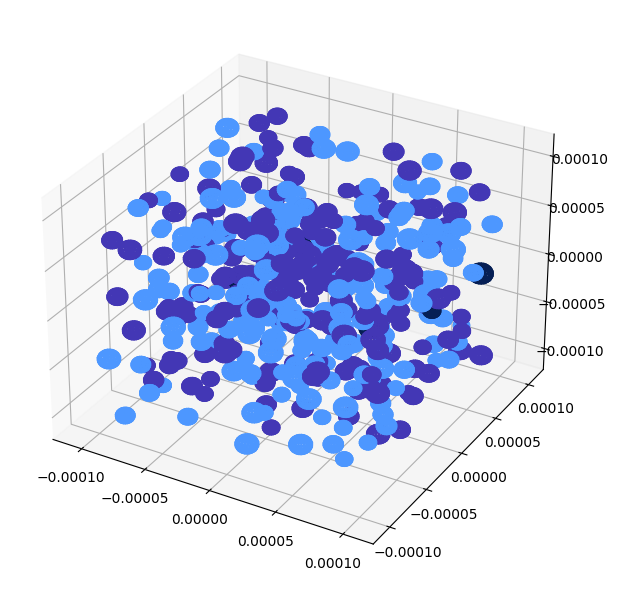

(<module 'matplotlib.pyplot' from '/home/hjorth/HBP/Snudda/venv/lib/python3.9/site-packages/matplotlib/pyplot.py'>,
 <Axes3DSubplot:>)

In [12]:
from snudda.plotting.plot_network import PlotNetwork
pn = PlotNetwork(network_path)
pn.plot(plot_axon=False, plot_dendrite=False, plot_synapses=False)

## Plot network connectivity

Here we plot the connection probabilites. When you create your own network this allows you to see how you should adjust your pruning to get the connectivity you want.

```exp_max_dist``` is the distance the pairwise experimental connectivity data was sampled within, ```exp_data_detailed``` specifies how many of the checked pairs were connected at the corresponding distances in ```exp_max_dist```.

Here we only plot the FS connectivity, the SPN connectivity can be inspected similarly.

The pruning parameter ```f1``` removes a fraction of all synapses (first step), while ```a3``` removes a fraction of all connected pairs. The latter is useful when you have tuned the other parameters, but need to alter the connection probability without affecting the number of synapses between connected neurons.

Assuming volume type: cube [cube or full]
Only using 20000 neurons of the connection data
Loading 405 neurons with 87716 synapses and 3 gap junctions
Number of neurons: 405
Synapse row 0 - 0.0 % time: 0.006380443002854008 seconds
Created connection matrix 0.10877199099923018 seconds
GJ row : 0 - 0.0 %  time : 0.0003392119979253039 seconds
Created gap junction connection matrix 0.00039158699655672535 seconds
Creating population dictionary
Done.
!!! Setting sideLen to None
Calculating synapse distance histogram
Creating dist histogram
n_synapses = 87716, at 0
Created distance histogram (optimised) in 0.11592340000061085 seconds
Saving cache to networks/example_microcircuit/network-synapses.hdf5-cache
Plotting connection probability FS to iSPN (synapses)
Centering in None : Keeping 200/200
Counting connections
Requested: 10000000.0 calculated [1000.]
P(d<0.0001) = 0.6929460580912863
P(d<0.00015) = 0.6055776892430279
P(d<0.00025) = 0.5165165165165165


/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1380: RuntimeWarning: invalid value encountered in true_divide
  p_con = np.divide(count_con, count_all)


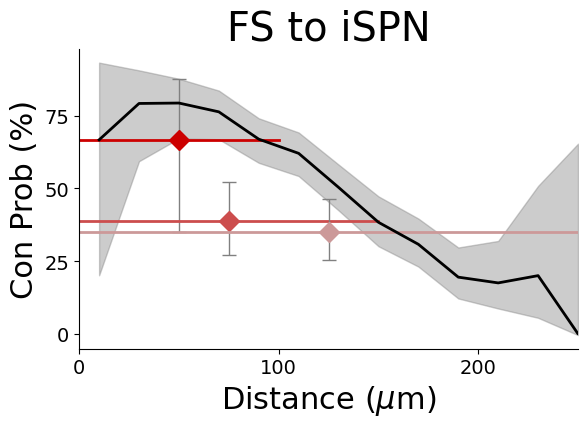

Wrote networks/example_microcircuit/figures/Network-distance-dependent-connection-probability-FS-to-iSPN-synapses-3D-dist.pdf
Plotting connection probability FS to dSPN (synapses)
Centering in None : Keeping 200/200
Counting connections
Requested: 10000000.0 calculated [1000.]
P(d<0.0001) = 0.8311688311688312
P(d<0.00015) = 0.7244623655913979
P(d<0.00025) = 0.6316316316316316


/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1380: RuntimeWarning: invalid value encountered in true_divide
  p_con = np.divide(count_con, count_all)


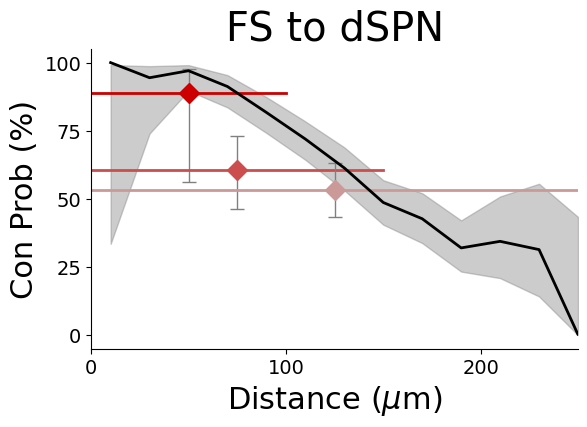

Wrote networks/example_microcircuit/figures/Network-distance-dependent-connection-probability-FS-to-dSPN-synapses-3D-dist.pdf


({0.0001: 0.8311688311688312,
  0.00015: 0.7244623655913979,
  0.00025: 0.6316316316316316},
 'networks/example_microcircuit/figures/Network-distance-dependent-connection-probability-FS-to-dSPN-synapses-3D-dist.pdf')

In [16]:
from snudda.analyse.analyse import SnuddaAnalyse

network_file = os.path.join(network_path, "network-synapses.hdf5")
nas = SnuddaAnalyse(network_file, volume_type="cube")

if False:
    # So few FS neurons in this small example, so no point plotting statistics in this example
    nas.plot_connection_probability("FS", "FS",
                                    dist_3d=True,
                                    connection_type="gapjunctions",
                                    exp_max_dist=[200e-6, 250e-6, 250e-6],
                                    exp_data_detailed=[(6, 78), (2, 6), (3, 7)], )

nas.plot_connection_probability("FS", "iSPN",
                                dist_3d=True,
                                exp_max_dist=[100e-6, 150e-6, 250e-6],
                                exp_data_detailed=[(6, 9), (21, 54), (27, 77)],
                                y_max=None)

nas.plot_connection_probability("FS", "dSPN",
                                dist_3d=True,
                                exp_max_dist=[100e-6, 150e-6, 250e-6],
                                exp_data_detailed=[(8, 9), (29, 48), (48, 90)],
                                y_max=None)

## Plotting number of synapses per pair

Here we plot the number of synapses connecting pairs of SPN of different types. The other connections can be inspected similarly.

When you tune this you will modify ```mu2```, ie. at which value is it 50% chance to keep the synapses between a connected synapses between a pair. If you are above this value it is quite likely all the synapses will be kept. Also ```softMax``` lets you put an upper limit on how many synapses between a pair is kept.

Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 200/200
Calculating max synapses
Calculating mean synapses
Plotting 5098 connections


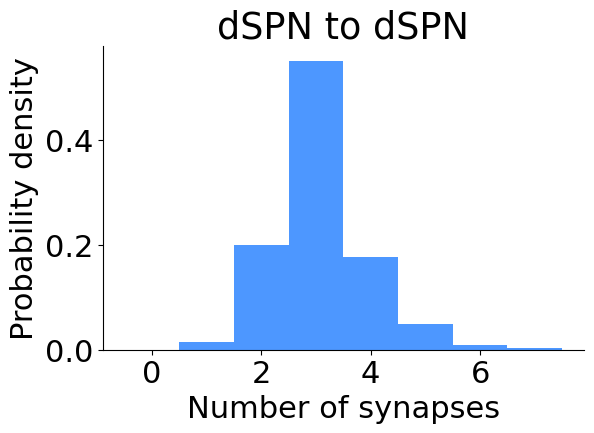

Wrote networks/example_microcircuit/figures/Network-number-of-synapses-from-dSPN-to-dSPN-per-cell.pdf
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 200/200
Calculating max synapses
Calculating mean synapses
Plotting 1625 connections


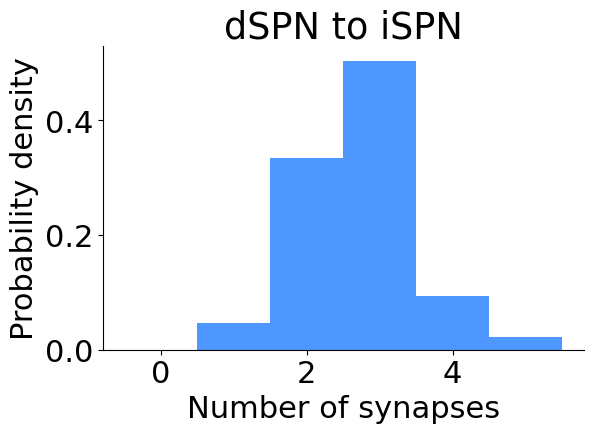

Wrote networks/example_microcircuit/figures/Network-number-of-synapses-from-dSPN-to-iSPN-per-cell.pdf
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 200/200
Calculating max synapses
Calculating mean synapses
Plotting 6370 connections


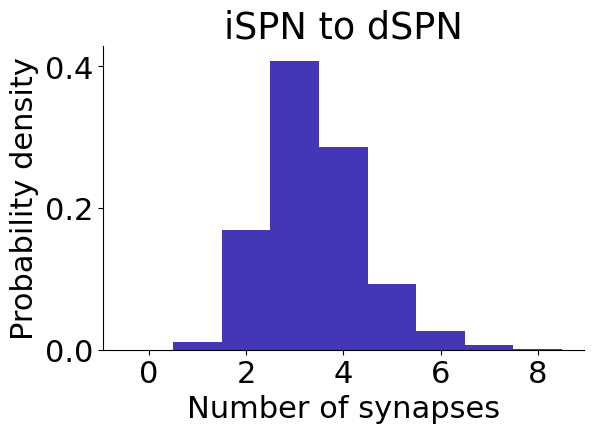

Wrote networks/example_microcircuit/figures/Network-number-of-synapses-from-iSPN-to-dSPN-per-cell.pdf
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 200/200
Calculating max synapses
Calculating mean synapses
Plotting 10474 connections


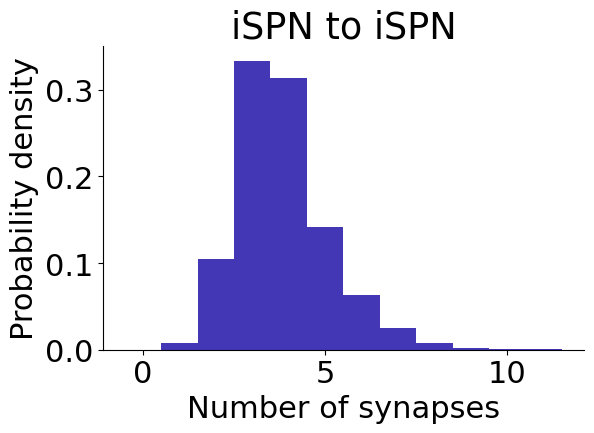

Wrote networks/example_microcircuit/figures/Network-number-of-synapses-from-iSPN-to-iSPN-per-cell.pdf


In [14]:
nas.plot_num_synapses_per_pair("dSPN", "dSPN")
nas.plot_num_synapses_per_pair("dSPN", "iSPN")
nas.plot_num_synapses_per_pair("iSPN", "dSPN")
nas.plot_num_synapses_per_pair("iSPN", "iSPN")

## Run the network

See the SimulateMicrocircuit notebook.